In [1]:
import glob
import numpy as np
import pandas as pd
import pandas
import datetime
import math
from matplotlib import pyplot as plt
from spacepy import pycdf
import aacgmv2
from scipy.interpolate import griddata

import warnings
warnings.filterwarnings(action='once')


This unreleased version of SpacePy is not supported by the SpacePy team.


In [2]:
def convert_gf_to_pandas(gf):
    """
    Function to convert gf hdf5 into a df. LEO position parameters are removed from the final df

    :param gf: gf df
    :return:
    """
    keys = list(gf.keys())
    keys.remove("LEO_Position")
    gf_dict = {k: gf[k][...] for k in keys}

    gf = pandas.DataFrame(gf_dict)

    return gf

def earth_radius(B):
    """
    Function to calculate earth radius

    :param B: latitude in degrees
    :return:
    """
    B = math.radians(B)  # converting into radians
    a = 6378.137  # Radius at sea level at equator
    b = 6356.752  # Radius at poles
    c = (a ** 2 * math.cos(B)) ** 2
    d = (b ** 2 * math.sin(B)) ** 2
    e = (a * math.cos(B)) ** 2
    f = (b * math.sin(B)) ** 2
    R = math.sqrt((c + d) / (e + f))
    return R

def geo2mag(latitude, longitude, altitude, timestamp):

    mlat, mlon, mlt = aacgmv2.wrapper.get_aacgm_coord(latitude, longitude, altitude, timestamp, method='’ALLOWTRACE’')

    return mlat, mlon, mlt

In [3]:
%%time

gf_files = glob.glob('../data/interim/Absolute_Ne/*/GR_OPER_NE__KBR_2F_*.cdf')
gf_files.sort()
for gf_file in gf_files:

    gf = pycdf.CDF(gf_file)
    gf = convert_gf_to_pandas(gf)

    # gf['Re'] = gf.Latitude.apply(lambda x: earth_radius(x))
    #
    # gf[['mlat','mlon', 'mlt']] = (gf.apply(lambda x: geo2mag(x['Latitude'], x['Longitude'], np.mean(x['Radius'] * 0.001 - x['Re']), x['Timestamp']), axis = 1).values.tolist())
    #
    # gf = gf.dropna()
    #
    # gf['hour'] = gf.mlt.apply(lambda x : int(x))

    gf.to_csv('../data/processed/Absolute_Ne_converted/GRACE/{filename}.csv'.format(filename=gf_file.split('/')[-1]))

CPU times: user 19min 8s, sys: 19.3 s, total: 19min 28s
Wall time: 20min 13s


In [8]:
%%time

gf_files = glob.glob('../data/interim/Absolute_Ne/*/GF_OPER_NE__KBR_2F_*.cdf')
gf_files.sort()
for gf_file in gf_files:
    try:

        gf = pycdf.CDF(gf_file)
        gf = convert_gf_to_pandas(gf)

        # gf['Re'] = gf.Latitude.apply(lambda x: earth_radius(x))
        #
        # gf[['mlat','mlon', 'mlt']] = (gf.apply(lambda x: geo2mag(x['Latitude'], x['Longitude'], np.mean(x['Radius'] * 0.001 - x['Re']), x['Timestamp']), axis = 1).values.tolist())
        #
        # gf = gf.dropna()
        #
        # gf['hour'] = gf.mlt.apply(lambda x : int(x))

        gf.to_csv('../data/processed/Absolute_Ne_converted/GRACEFO/{filename}.csv'.format(filename=gf_file.split('/')[-1]))
    except:
        print(gf_file)

CPU times: user 3min 15s, sys: 3.26 s, total: 3min 18s
Wall time: 3min 27s


In [197]:
%%time
# pd.options.mode.chained_assignment = None
# loop through hours

gf_files = glob.glob('../data/processed/Absolute_Ne/GRACE/*.csv')
gf_files.sort()


for i in iter(range(0,24)):

    gf_plot = pd.DataFrame()

    for j in iter(range(0,len(gf_files))):

        gf = pd.read_csv(gf_files[j]).drop(['Unnamed: 0'],axis=1)

        # select hour
        gf = gf[gf['hour'] == i]

        gf_plot = gf_plot.append(gf)


    # plot
    plt.figure(figsize=(18,3))
    plt.suptitle('Hour {i}'.format(i=i),fontweight='bold')

    # bin lat
    gf_plot['mlat'] = np.round(gf_plot['mlat'],0)

    # extract mean, max, min
    gf_groupby = gf_plot.groupby('mlat').agg({'Absolute_Ne': ['mean', 'min', 'max']})


    ax1 = plt.subplot(1,3,1)
    plt.xlim(-90,90)
    ax1.scatter(gf_plot['mlat'], gf_plot['Absolute_Ne'])
#     ax1.ylim(-10e11, 10e11)

    ax2 = plt.subplot(1,3,2)
    plt.xlim(-90,90)
    ax2.plot(gf_groupby.index, gf_groupby['Absolute_Ne']['mean'])
#     ax2.ylim(-10e10, 10e10)

    ax3 = plt.subplot(1,3,3)
    plt.xlim(-90,90)
    ax3.plot(gf_groupby.index, gf_groupby['Absolute_Ne']['mean'])
    ax3.plot(gf_groupby.index, gf_groupby['Absolute_Ne']['max'])
    ax3.plot(gf_groupby.index, gf_groupby['Absolute_Ne']['min'])
#     ax3.ylim(-10e11, 10e11)

    plt.savefig('../figures/GR_maglat_Ne_{hour}.png'.format(hour=i))
    plt.close()

CPU times: user 2h 18min 18s, sys: 1h 4min 6s, total: 3h 22min 25s
Wall time: 3h 24min 45s


In [198]:
%%time
# pd.options.mode.chained_assignment = None
# loop through hours

gf_files = glob.glob('../data/processed/Absolute_Ne/GRACEFO/*.csv')
gf_files.sort()


for i in iter(range(0,24)):

    gf_plot = pd.DataFrame()

    for j in iter(range(0,len(gf_files))):

        gf = pd.read_csv(gf_files[j]).drop(['Unnamed: 0'],axis=1)

        # select hour
        gf = gf[gf['hour'] == i]

        gf_plot = gf_plot.append(gf)


    # plot
    plt.figure(figsize=(18,3))
    plt.suptitle('Hour {i}'.format(i=i),fontweight='bold')

    # bin lat
    gf_plot['mlat'] = np.round(gf_plot['mlat'],0)

    # extract mean, max, min
    gf_groupby = gf_plot.groupby('mlat').agg({'Absolute_Ne': ['mean', 'min', 'max']})


    ax1 = plt.subplot(1,3,1)
    plt.xlim(-90,90)
    ax1.scatter(gf_plot['mlat'], gf_plot['Absolute_Ne'])
#     ax1.ylim(-10e11, 10e11)

    ax2 = plt.subplot(1,3,2)
    plt.xlim(-90,90)
    ax2.plot(gf_groupby.index, gf_groupby['Absolute_Ne']['mean'])
#     ax2.ylim(-10e10, 10e10)

    ax3 = plt.subplot(1,3,3)
    plt.xlim(-90,90)
    ax3.plot(gf_groupby.index, gf_groupby['Absolute_Ne']['mean'])
    ax3.plot(gf_groupby.index, gf_groupby['Absolute_Ne']['max'])
    ax3.plot(gf_groupby.index, gf_groupby['Absolute_Ne']['min'])
#     ax3.ylim(-10e11, 10e11)

    plt.savefig('../figures/GF_maglat_Ne_{hour}.png'.format(hour=i))
    plt.close()

CPU times: user 12min 54s, sys: 2min 54s, total: 15min 49s
Wall time: 16min 2s


In [288]:
gr = pd.read_csv('../tables/conjunctionsGR.csv').drop(['Unnamed: 0'],axis=1)
gf = pd.read_csv('../tables/conjunctionsGF.csv').drop(['Unnamed: 0'],axis=1)

f107 = pd.read_csv('../data/external/f107/Kp_ap_Ap_SN_F107_since_1932.txt', delimiter=r"\s+", comment='#')

In [291]:
f107['date_simplified'] = f107.apply(lambda x: datetime.datetime(int(x['YYYY']),int(x['MM']),int(x['DD'])), axis = 1)

gr['date'] = pd.to_datetime(gr['date'])
gr['date_simplified']  = gr['date'].apply(lambda x: pd.to_datetime(x.strftime('%Y-%m-%d')))

gf['date'] = pd.to_datetime(gf['date'])
gf['date_simplified']  = gf['date'].apply(lambda x: pd.to_datetime(x.strftime('%Y-%m-%d')))

In [292]:
gf_f107 = gf.merge(f107, left_on='date_simplified', right_on='date_simplified')

gr_f107 = gr.merge(f107, left_on='date_simplified', right_on='date_simplified')



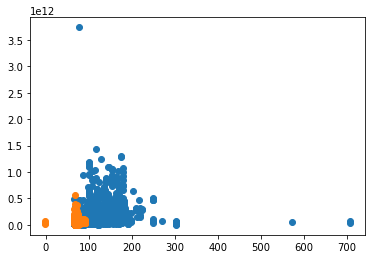

In [302]:
plt.scatter(gr_f107['F10.7obs'],(gr_f107['ne_radar']))
plt.scatter(gf_f107['F10.7obs'],(gf_f107['ne_radar']))

# ident = [0.0, 800.0]
# plt.plot(ident,ident)

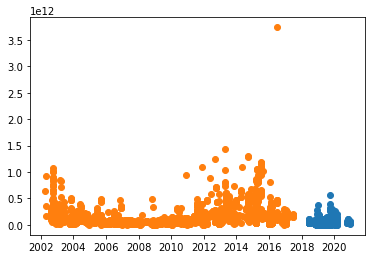

In [307]:
plt.scatter(gf['date_simplified'], (gf['ne_radar']))
plt.scatter(gr['date_simplified'], (gr['ne_radar']))

# plt.scatter(f107['date_simplified'], 10**f107['F10.7obs'])


CPU times: user 3min 40s, sys: 13 s, total: 3min 53s
Wall time: 3min 59s


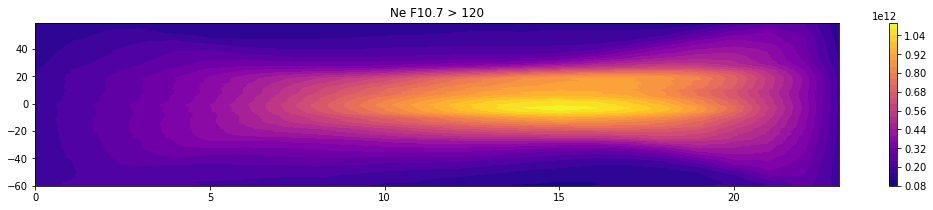

In [4]:
%%time
f107 = pd.read_csv('../data/external/f107/Kp_ap_Ap_SN_F107_since_1932.txt', delimiter=r"\s+", comment='#')

f107['date_simplified'] = f107.apply(lambda x: datetime.datetime(int(x['YYYY']),int(x['MM']),int(x['DD'])), axis = 1)

f107 = f107[f107['F10.7obs']>=120]
f107 = f107[(f107['YYYY']>2000)]

f107 = f107.reset_index(drop=True)

# target grid to interpolate to
yi = np.arange(-60,60,1)
xi = np.arange(0,24,1)
xi,yi = np.meshgrid(xi,yi)

list_zi = []

for i in range(0,len(f107)):

    date = f107['date_simplified'][i]

    try:

        gf_file = glob.glob('../data/processed/Absolute_Ne/*/GR_OPER_NE__KBR_2F_{date}*.cdf.csv'.format(
            date=date.strftime('%Y%m%d')))

        gf = pd.read_csv(gf_file[0], usecols=['Latitude','hour','Absolute_Ne'])

        y= gf['Latitude']
        x = gf['hour']
        z = gf['Absolute_Ne']

        # interpolate
        zi = griddata((x,y),z,(xi,yi),method='linear')
        list_zi.append(zi)

    except:
        pass

zi = np.nanmean(np.array(list_zi),axis=0)

plt.figure(figsize=(18,3))
CS = plt.contourf(xi, yi, zi, 25,cmap='plasma')
# plt.pcolormesh(xi, yi, zi)
plt.colorbar()
plt.title('Ne F10.7 > 120')
plt.savefig('gr_hight.png')

CPU times: user 6min 5s, sys: 18.7 s, total: 6min 24s
Wall time: 6min 41s


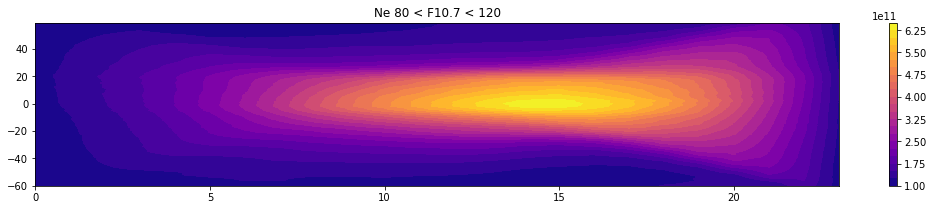

In [3]:
%%time
f107 = pd.read_csv('../data/external/f107/Kp_ap_Ap_SN_F107_since_1932.txt', delimiter=r"\s+", comment='#')

f107['date_simplified'] = f107.apply(lambda x: datetime.datetime(int(x['YYYY']),int(x['MM']),int(x['DD'])), axis = 1)

f107 = f107[(f107['F10.7obs']>=80) & (f107['F10.7obs']<120)]
f107 = f107[(f107['YYYY']>2000)]

f107 = f107.reset_index(drop=True)

# target grid to interpolate to
yi = np.arange(-60,60,1)
xi = np.arange(0,24,1)
xi,yi = np.meshgrid(xi,yi)

list_zi = []

for i in range(0,len(f107)):

    date = f107['date_simplified'][i]

    try:

        gf_file = glob.glob('../data/processed/Absolute_Ne/*/GR_OPER_NE__KBR_2F_{date}*.cdf.csv'.format(
            date=date.strftime('%Y%m%d')))

        gf = pd.read_csv(gf_file[0], usecols=['Latitude','hour','Absolute_Ne'])

        y= gf['Latitude']
        x = gf['hour']
        z = gf['Absolute_Ne']

        # interpolate
        zi = griddata((x,y),z,(xi,yi),method='linear')
        list_zi.append(zi)

    except:
        pass

zi = np.nanmean(np.array(list_zi),axis=0)

plt.figure(figsize=(18,3))
CS = plt.contourf(xi, yi, zi, 25,cmap='plasma')
# plt.pcolormesh(xi, yi, zi)
plt.colorbar()
plt.title('Ne 80 < F10.7 < 120')
plt.savefig('gr_medium.png')

CPU times: user 5min 53s, sys: 18.3 s, total: 6min 11s
Wall time: 7min 18s


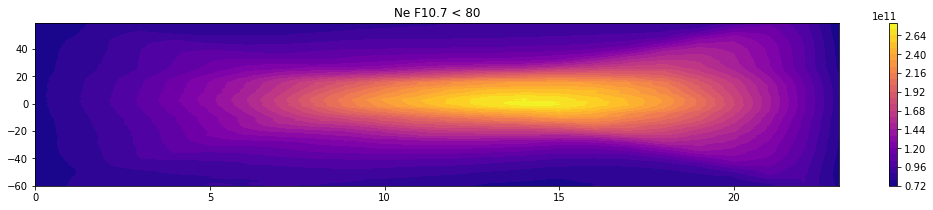

In [2]:
%%time
f107 = pd.read_csv('../data/external/f107/Kp_ap_Ap_SN_F107_since_1932.txt', delimiter=r"\s+", comment='#')

f107['date_simplified'] = f107.apply(lambda x: datetime.datetime(int(x['YYYY']),int(x['MM']),int(x['DD'])), axis = 1)

f107 = f107[(f107['F10.7obs']<80)]
f107 = f107[(f107['YYYY']>2000)]

f107 = f107.reset_index(drop=True)

# target grid to interpolate to
yi = np.arange(-60,60,1)
xi = np.arange(0,24,1)
xi,yi = np.meshgrid(xi,yi)

list_zi = []

for i in range(0,len(f107)):

    date = f107['date_simplified'][i]

    try:

        gf_file = glob.glob('../data/processed/Absolute_Ne/*/GR_OPER_NE__KBR_2F_{date}*.cdf.csv'.format(
            date=date.strftime('%Y%m%d')))

        gf = pd.read_csv(gf_file[0], usecols=['Latitude','hour','Absolute_Ne'])

        y= gf['Latitude']
        x = gf['hour']
        z = gf['Absolute_Ne']

        # interpolate
        zi = griddata((x,y),z,(xi,yi),method='linear')
        list_zi.append(zi)

    except:
        pass

zi = np.nanmean(np.array(list_zi),axis=0)

plt.figure(figsize=(18,3))
CS = plt.contourf(xi, yi, zi, 25,cmap='plasma')
# plt.pcolormesh(xi, yi, zi)
plt.colorbar()
plt.title('Ne F10.7 < 80')
plt.savefig('gr_low.png')

In [2]:
%%time
f107 = pd.read_csv('../data/external/f107/Kp_ap_Ap_SN_F107_since_1932.txt', delimiter=r"\s+", comment='#')

f107['date_simplified'] = f107.apply(lambda x: datetime.datetime(int(x['YYYY']),int(x['MM']),int(x['DD'])), axis = 1)

f107 = f107[f107['F10.7obs']>=120]
f107 = f107[(f107['YYYY']>2000)&(f107['YYYY']<2003)]

f107 = f107.reset_index(drop=True)

# # target grid to interpolate to
# yi = np.arange(-60,60,2)
# xi = np.arange(0,24,1)
# xi,yi = np.meshgrid(xi,yi)

gf_plot = pd.DataFrame()

for i in range(0,len(f107)):

    date = f107['date_simplified'][i]

    try:

        gf_file = glob.glob('../data/processed/Absolute_Ne/*/G*_OPER_NE__KBR_2F_{date}*.cdf.csv'.format(
            date=date.strftime('%Y%m%d')))

        gf = pd.read_csv(gf_file[0], usecols=['Latitude','mlt','Absolute_Ne'])

        gf_plot = gf_plot.append(gf)

    except:
        pass

yi = np.arange(-60,60,0.25)
xi = np.arange(0,24,0.1)
xi,yi = np.meshgrid(xi,yi)

zi = griddata((gf_plot['mlt'],gf_plot['Latitude']),gf_plot['Absolute_Ne'],(xi,yi),method='linear')

fig = plt.figure(figsize=(18,3))
ax = fig.add_subplot(111)
plt.contourf(xi,yi,zi, vmin=0.0, vmax=1.5E12, cmap='plasma')
plt.colorbar()

# plt.pcolormesh(xi, yi, zi)
plt.colorbar()
plt.title('Ne F10.7 > 120')
plt.savefig('../figures/gr_high.png')

CPU times: user 8.24 s, sys: 4.92 s, total: 13.2 s
Wall time: 13.7 s


In [33]:
zi.shape

(480, 240)